## Import modules

In [9]:
import imblearn
import pandas as pd
import sklearn
import seaborn as sns
import dill
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from joblib import dump, load
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

## Data loading

In [11]:
random_state = 809
# Load data from sources
data=pd.read_csv('C:\\Users\\apurv Khandelwal\\Desktop\\Lending Club\\Lending Club\\Lending_Club_Data.csv')
# Load jupyter session
#dill.load_session('logistic_forest.db')
# Create test andd train
random_state = 809

## Data preprocessing

In [13]:
# Data cleaning and processing
data = data.fillna(0) # Fill na values with 0
for i in data.columns:  # Transform non-numeric types to string
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('str')
# Enumerating categorical data
encoder = preprocessing.OrdinalEncoder()
encoder.fit(data)
data_encoded = encoder.transform(data)
# Dataframe creation
df = pd.DataFrame(data_encoded,columns=data.columns)
df = df.drop(["dti",
              "dti_joint",
              "emp_title",
              "dti_joint.1",
              "loan_id",
              "int_rate",
              "total_pymnt",
              "total_rec_int",
              "total_rec_late_fee",
              "total_rec_prncp",
              "recoveries"], axis=1)
variables = list(df.columns)
variables.remove('loan_status')
df.head(10)

,loan_status,loan_amnt,term,sub_grade,installment,issue_d,annual_inc,emp_length,verification_status,purpose,...,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,revol_bal_joint,annual_inc_joint,verification_status_joint
0,1.0,1320.0,1.0,15.0,53744.0,0.0,38792.0,3.0,2.0,2.0,...,1083.0,0.0,333044.0,352334.0,29.0,144867.0,1008.0,0.0,0.0,0.0
1,0.0,760.0,1.0,12.0,30020.0,0.0,16885.0,3.0,2.0,2.0,...,924.0,0.0,125061.0,262323.0,29.0,30574.0,875.0,0.0,0.0,0.0
2,0.0,560.0,1.0,19.0,24962.0,0.0,27275.0,1.0,0.0,2.0,...,1188.0,0.0,13020.0,3148.0,5.0,13061.0,744.0,0.0,0.0,0.0
3,0.0,408.0,0.0,10.0,23288.0,0.0,32096.0,2.0,1.0,2.0,...,713.0,0.0,89648.0,78688.0,23.0,91867.0,435.0,0.0,0.0,0.0
4,0.0,623.0,0.0,8.0,35716.0,0.0,13341.0,11.0,0.0,2.0,...,325.0,0.0,15830.0,68466.0,13.0,15871.0,4067.0,0.0,0.0,0.0
5,0.0,1160.0,1.0,18.0,50840.0,0.0,22400.0,7.0,2.0,8.0,...,455.0,0.0,9677.0,15605.0,7.0,9717.0,1424.0,0.0,0.0,0.0
6,0.0,560.0,0.0,17.0,35958.0,0.0,33120.0,0.0,0.0,10.0,...,536.0,0.0,90505.0,110099.0,21.0,92790.0,232.0,0.0,0.0,0.0
7,0.0,560.0,0.0,0.0,29280.0,0.0,29364.0,2.0,0.0,1.0,...,689.0,0.0,109098.0,113261.0,22.0,112214.0,1721.0,0.0,0.0,0.0
8,0.0,361.0,0.0,33.0,26810.0,0.0,25396.0,11.0,0.0,10.0,...,838.0,0.0,40488.0,33881.0,7.0,40537.0,477.0,0.0,0.0,0.0
9,0.0,80.0,0.0,16.0,4003.0,0.0,3618.0,4.0,2.0,9.0,...,841.0,0.0,7003.0,1999.0,11.0,7043.0,134.0,0.0,0.0,0.0


## Split data

In [14]:
# function to plot vizualizations for Cross-validation splits. 

def plot_cv_indices (cv, X, y, n_splits, lw =10):
    fig, ax=plt.subplots(figsize=(15,8))    
# Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):# Fill in indices with the training/test groups
        indices = np.array([np.nan]*len(X)) 
        indices[tt]=1
        indices[tr]= 0
        # Visualize the results
        ax.scatter(range(len(indices)), [ii+.5]*len(indices),c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,vmin=-.2, vmax=1.2)
        # Plot the data classes
    ax.scatter(range(len(X)), [ii+1.5]*len(X), c=y, marker='_', lw=lw,cmap=plt.cm.Paired)
    # Formatting
    yticklabels=list(range(n_splits))+['Class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels = yticklabels, xlabel='Sample index', ylabel="CV iteration", ylim=[n_splits+2.2,-.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

def show_images():
    plt.gray()
    fig, ax=plt.subplots(nrows=2, ncols=5, figsize=(15,10))
    ax=ax.flatten()
    for index in range(0,10):
        ax[index].matshow(datasets.load_digits().images[index])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1),
                                                    df['loan_status'], test_size=0.3,
                                                    random_state=random_state)

In [16]:
df = pd.DataFrame(X_train, columns = variables)
df['loan_status'] = y_train

## Check data balancing

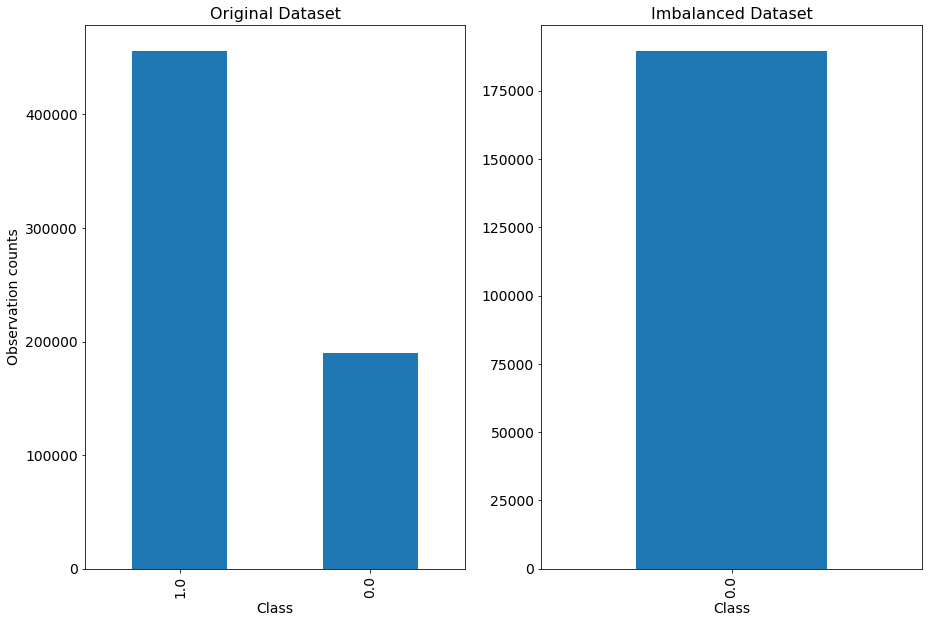

In [56]:
df_0 = df[df['loan_status']==0]
df_1 = df[df['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

Clearly we appreciate a significant imbalance of class 0 with respect to class 1.

Thus, we need to balance the data. In class we learned about several methods to balance imbalanced datasets.
In this case, we will use smote procedure.

In [57]:
model_imb = LogisticRegression(penalty="l1",
                                    solver="liblinear",
                                    max_iter=int(1e6),
                                    warm_start=True)
model_imb.fit(df[variables], df['loan_status'])

In [77]:
print(f'Logistic score imbalanced: {model_imb.score(X_test, y_test)}')

Logistic score imbalanced: 0.7243539234467055


### Confusion matrix

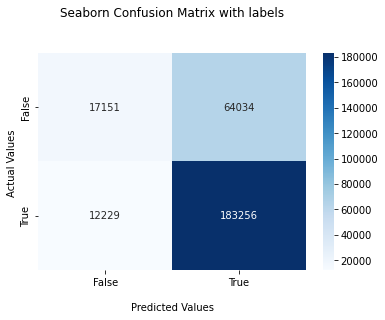

In [79]:
imbalanced_predicted = model_imb.predict(X_test)
cf_matrix = confusion_matrix( y_test, imbalanced_predicted)
ax = sns.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()



### Plot ROC curves

In [17]:
def plot_roc_precision(model, X_test, y_test):
    fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,10))
    plot_roc_curve(model, X_test, y_test, ax=ax)
    plot_precision_recall_curve(model, X_test, y_test, ax=ax1)
    ax.set_title('ROC', fontsize=18)
    ax1.set_title('Precision Recall', fontsize=18)
    ax.legend(fontsize=15)
    ax1.legend(fontsize=15)
    plt.suptitle('Balanced Dataset', fontsize=20)
    plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


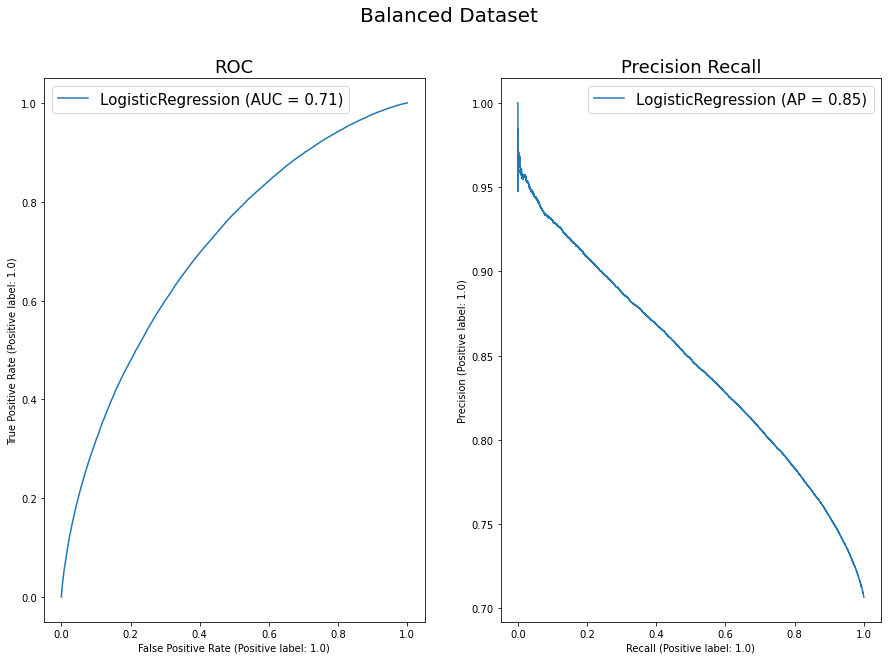

In [81]:
plot_roc_precision(model_imb,  X_test, y_test)

The area under the curve is far from being maximized.

### Data balancing with oversampling

In [61]:
oversampler = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
oversample_x, oversample_y = oversampler.fit_resample(df[variables], df['loan_status'])
df_oversampled = pd.DataFrame(oversample_x, columns = variables)
df_oversampled['loan_status'] = oversample_y

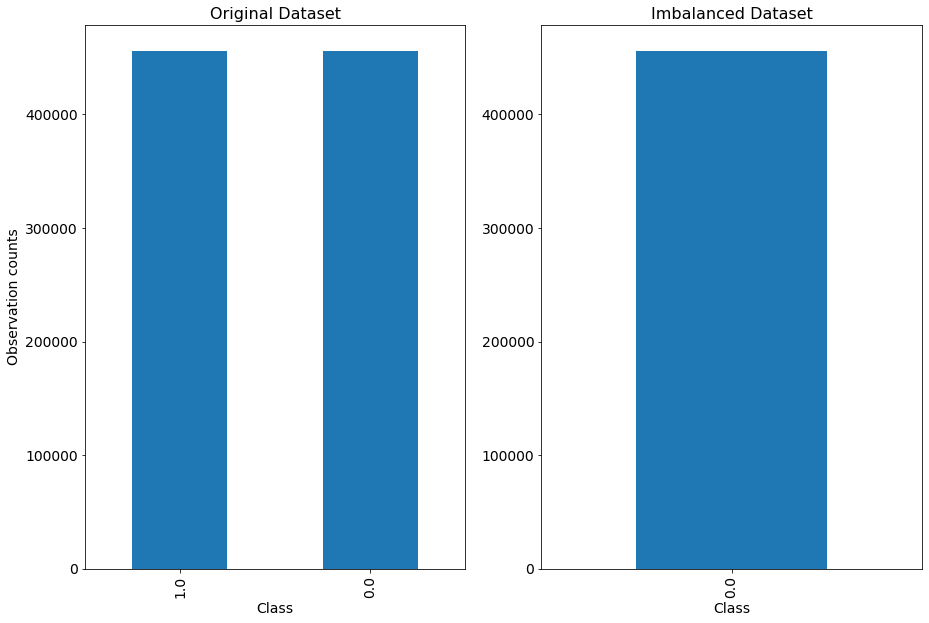

In [62]:
df_0_under = df_oversampled[df_oversampled['loan_status']==0]
df_1_under = df_oversampled[df_oversampled['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df_oversampled['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0_under['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

In [63]:
model_balanced = LogisticRegression(penalty="l1",
                                    solver="liblinear",
                                    max_iter=int(1e6),
                                    warm_start=True)
model_balanced.fit(df_oversampled[variables], df_oversampled['loan_status'])
balanced_predicted = model_balanced.predict(df_oversampled[variables])

In [83]:
print(f'Logistic score oversampled: {model_balanced.score(X_test, y_test)}')

Logistic score oversampled: 0.6533848989771207


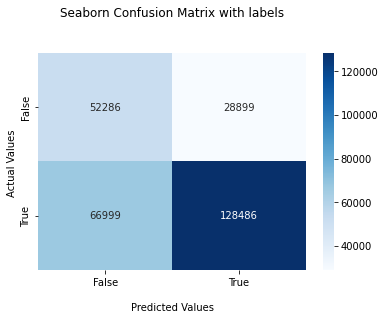

In [82]:
balanced_predicted = model_balanced.predict(X_test)
cf_matrix_balanced = confusion_matrix( y_test, balanced_predicted)
ax = sns.heatmap(cf_matrix_balanced, annot=True,cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


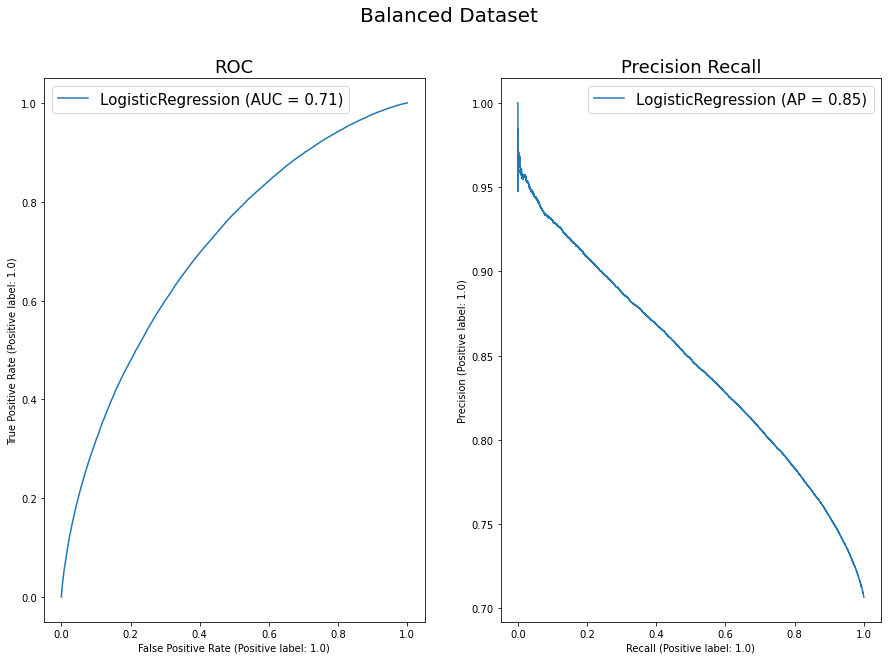

In [85]:
plot_roc_precision(model_imb,  X_test, y_test)

Note that the ROC and precission recall curves indicate that oversampoling the dataset does not improve the performance of the model. 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Cross-validation score - LDA: 0.8446447762921423
Test score - LDA: 0.845526604603455


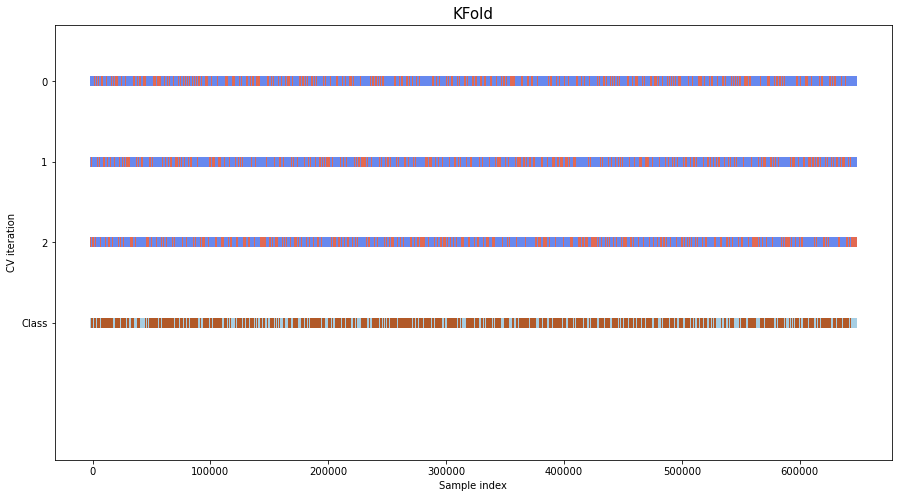

In [20]:

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=random_state)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LinearDiscriminantAnalysis(
                                                                    solver="svd",
                                                                    ) 
                                 ]])

cv = KFold(n_splits=3, shuffle=True)

plot = plot_cv_indices(cv, X_train, y_train, 3)

param_grid = {}
grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='average_precision',
                            cv=cv,
                            verbose=True,
                            n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.fit_transform(X_test, y_test)
cv_score = grid_search.best_score_
LDA_coef = grid_search.best_estimator_["classifier"]
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score - LDA: {cv_score}\nTest score - LDA: {test_score}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\apurv Khandelwal\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\apurv Khandelwal\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\apurv Khandelwal\anaconda3\lib\site-packages\imblearn\pipeline.py", line 267, in fit
    fit_params_steps = self._check_fit_params(**fit_params)
  File "C:\Users\apurv Khandelwal\anaconda3\lib\site-packages\sklearn\pipeline.py", line 297, in _check_fit_params
    fit_params

ValueError: too many values to unpack (expected 2)

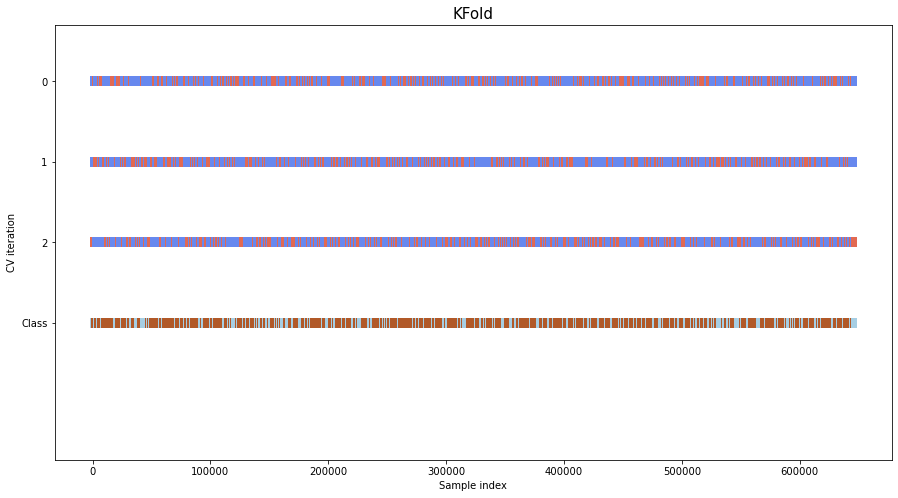

In [18]:
# We Create a Pipeline to do three things to the training FOLDS:
#1- Apply Smote to it
#2- Apply a MinMax Scaler to the data
#3- Apply the KNN9rrrrrrrrrrrrrrrrrr

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=random_state)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(penalty="l1",
                                                                    solver="liblinear",
                                                                    max_iter=int(1e6),
                                                                    warm_start=True), 
                                ]])
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
plot = plot_cv_indices(cv, X_train, y_train, 3)

param_grid = {'smote__k_neighbors': [1, 2, 3, 4, 5, 10]}
grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='average_precision',
                            cv=cv,
                            verbose=True,
                            n_jobs=-1)
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score - Logistic Regression: {cv_score}\nTest score - Logistic Regression: {test_score}')

In [53]:
# Retreive best model 
optimal_logistic = grid_search.best_estimator_["classifier"]
print(grid_search.best_estimator_["smote"])
print(model_imb.score(X_test, y_test))

SMOTE(k_neighbors=1, random_state=809)
0.6532258647486174
0.7243719955181263


In [9]:
grid_search.best_estimator_["classifier"].coef_[0]

array([-2.96657097e-01, -5.86283800e-01, -2.80318795e+00, -5.96372051e-01,
        2.09761240e-02,  4.28770477e-01,  8.11435062e-02, -5.56734067e-02,
       -9.66676312e-02, -3.13927130e-01,  5.38974095e-02,  7.69917397e-02,
        4.13221431e-01, -8.71408228e-01, -5.52185128e-01, -1.72769318e-02,
       -6.60234757e-01,  1.86404027e+00, -1.07455530e+00,  1.06912298e-01,
       -2.62326423e+00, -5.76274957e-01, -1.44607109e+00, -2.87884080e+00,
       -1.16074675e+00,  9.49736408e-02, -4.67916074e-02, -7.05135119e-01,
       -3.59766009e-01,  3.48769575e-01,  8.27025941e-02,  0.00000000e+00,
       -4.51029412e-01,  4.52459381e-01,  2.63046396e+00, -9.95951162e-02,
        9.62728684e-01, -5.92317509e-01,  7.25475238e-01,  1.18562413e-03])

In [10]:
dump(grid_search, 'logistic_forest.joblib') 

['logistic_forest.joblib']

Let's see the effect of smote in the training set:

### Logistic coefficients

In [11]:
list_tuples = list(zip(variables, np.round(optimal_logistic.coef_[0], 2), np.round(LDA_coef.coef_[0], 2) ))
coef_df = pd.DataFrame(list_tuples, columns =['Predictor', 'Logistic COEF', 'LDA COEF'])
coef_df

,Predictor,Logistic COEF
0,loan_amnt,-0.30
1,term,-0.59
2,sub_grade,-2.80
3,installment,-0.60
4,issue_d,0.02
5,annual_inc,0.43
6,emp_length,0.08
7,verification_status,-0.06
8,purpose,-0.10
9,home_ownership,-0.31


### Omitted predictors by Logistic model

Note that we are using l1 norm as penalty in the logistic model. Therefore, the shrinkage is performed, allogwing variable selection.

In [4]:
# Omitted
coef_df[coef_df['Logistic COEF'] == 0]

,Predictor,Logistic COEF
31,tax_liens,0.0
39,verification_status_joint,0.0


### Selected predictors by Logistic model

In [13]:
# Selected
coef_df[coef_df['Logistic COEF'] != 0]

,Predictor,Logistic COEF
0,loan_amnt,-0.30
1,term,-0.59
2,sub_grade,-2.80
3,installment,-0.60
4,issue_d,0.02
5,annual_inc,0.43
6,emp_length,0.08
7,verification_status,-0.06
8,purpose,-0.10
9,home_ownership,-0.31


### Retrieve oversampled dataset 

In [86]:
smote_oversampler = grid_search.best_estimator_["smote"]
smote_x, smote_y = smote_oversampler.fit_resample(df.drop(['loan_status'], axis=1), df['loan_status'])

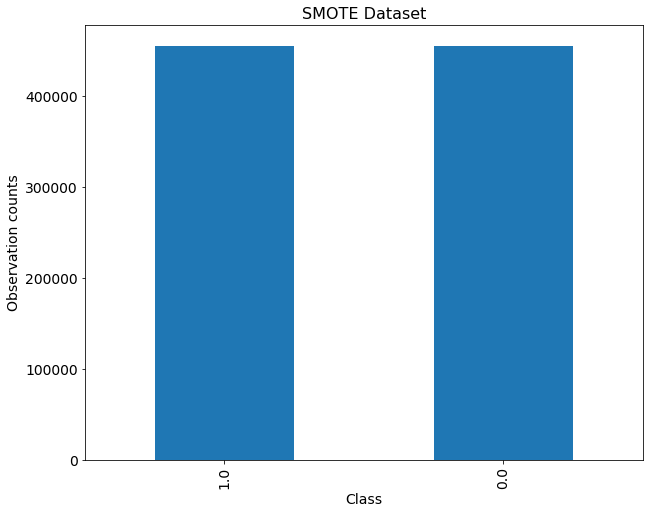

In [87]:
df_smote = pd.DataFrame(smote_x, columns = variables)
df_smote['loan_status'] = smote_y
fig, ax = plt.subplots(figsize=(10, 8))
df_smote['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
ax.set_title('SMOTE Dataset', fontsize=16)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
plt.show()

In [98]:
scaler = grid_search.best_estimator_["scaler"]
X_test_scaled = X_test
X_test_scaled[X_test_scaled.columns] = scaler.fit_transform(X_test[X_test.columns])
X_test_scaled

,loan_amnt,term,sub_grade,installment,issue_d,annual_inc,emp_length,verification_status,purpose,home_ownership,...,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,revol_bal_joint,annual_inc_joint,verification_status_joint
276768,0.115385,0.0,0.117647,0.120181,0.278689,0.050583,0.000000,1.0,0.250000,0.75,...,0.409579,0.0,0.002377,0.000114,0.110294,0.005003,0.009960,0.000000,0.000000,0.000000
544949,0.451282,0.0,0.441176,0.641604,0.606557,0.567060,0.090909,0.5,0.166667,0.25,...,0.766309,0.0,0.817756,0.771460,0.169118,0.329526,0.036976,0.000000,0.000000,0.000000
901970,0.487179,1.0,0.735294,0.617923,0.967213,0.180544,1.000000,0.0,0.666667,1.00,...,0.354253,0.0,0.013091,0.005911,0.095588,0.027289,0.065084,0.000000,0.000000,0.000000
675169,0.512821,1.0,0.352941,0.477004,0.721311,0.729828,0.363636,0.5,0.166667,1.00,...,0.868704,0.0,0.166370,0.146478,0.051471,0.345346,0.360486,0.000000,0.000000,0.000000
448234,1.000000,1.0,0.294118,0.860551,0.491803,0.398740,0.363636,0.5,0.083333,0.25,...,0.682907,0.0,0.923433,0.910727,0.272059,0.732322,0.145722,0.642115,0.770658,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638016,0.282051,0.0,0.205882,0.358293,0.688525,0.421776,0.909091,0.0,0.083333,0.25,...,0.813377,0.0,0.544366,0.518184,0.125000,0.344072,0.077910,0.000000,0.000000,0.000000
372446,0.743590,1.0,0.235294,0.648855,0.393443,0.861556,0.181818,0.0,0.166667,0.25,...,0.733278,0.0,0.170474,0.326852,0.338235,0.128054,0.551235,0.000000,0.000000,0.000000
333,0.025641,0.0,0.352941,0.025181,0.000000,0.517495,1.000000,0.5,0.250000,0.25,...,0.907514,0.0,0.250046,0.209873,0.205882,0.529324,0.015828,0.000000,0.000000,0.000000
35394,0.871795,0.0,0.323529,0.965803,0.016393,0.674068,0.181818,1.0,0.166667,1.00,...,0.882742,0.0,0.146923,0.151459,0.161765,0.304351,0.405785,0.000000,0.000000,0.000000


/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


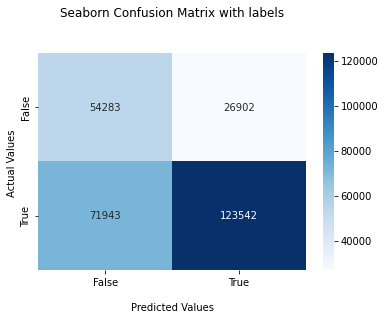

In [99]:
smote_predicted = optimal_logistic.predict(X_test_scaled)
cf_matrix_smote = confusion_matrix( y_test, smote_predicted)
ax = sns.heatmap(cf_matrix_smote, annot=True,cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.p

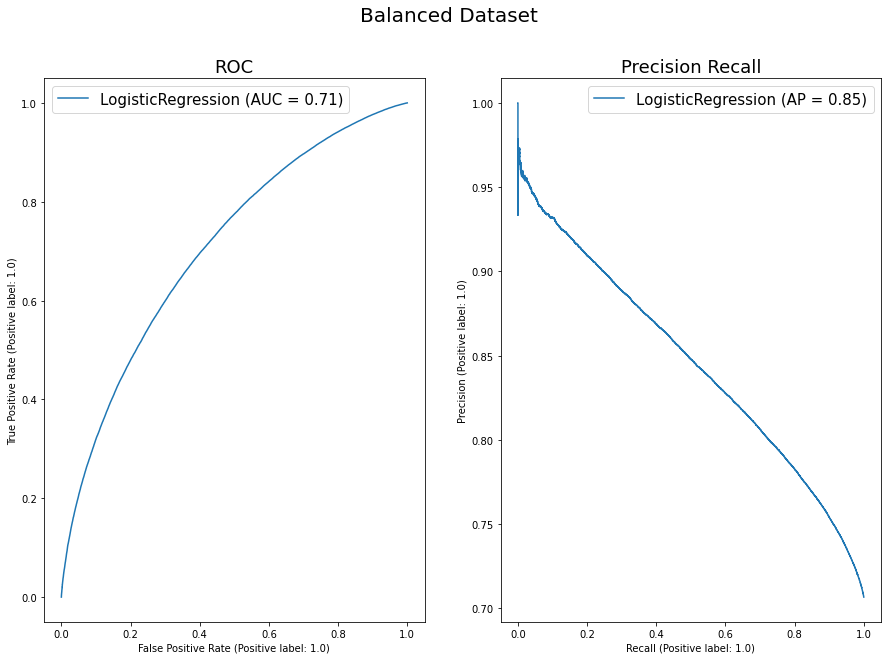

In [100]:
plot_roc_precision(optimal_logistic,  X_test, y_test)

### Random forest

Let's scale the oversampled data:

In [110]:
df_smote_scaled = df_smote
df_smote_scaled[df_smote_scaled.columns] = scaler.fit_transform(df_smote_scaled[df_smote_scaled.columns])

Delete penalized variables by logistic

In [111]:
df_smote_scaled = df_smote_scaled.drop(["tax_liens",
              "verification_status_joint"], axis=1)

#### Find optimal hyperparameters

In [ ]:
# Parameter optimization
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [0.5, 'sqrt', 'auto']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}

rfc = RandomForestClassifier()
n_iter = 20 # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
cv = 3 # Cross-validation folds
n_jobs = -1 # Uses all cores available
verbose = 5 # Controls how much the algo will print text to inform us of what is going on
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions =param_grid, n_iter = n_iter, cv = cv, verbose=verbose, random_state=random_state, n_jobs = n_jobs)
time_start = time.time()
rf_random.fit(X_train, y_train)
time_end = time.time()
print('time cost', time_end - time_start, 's')
best_parameters = rf_random.best_params_
print('The best Parameters are:')
for key, item in best_parameters.items():
    print(f'- {key}: {item}')

In [108]:
dill.dump_session('logistic_forest.db')